In [1]:
from seagul.rl.algos import sac, ppo
from seagul.rl.algos.sac_ray import ray_sac
from seagul.rl.algos.sac_sym import sac_sym
from seagul.nn import MLP
from seagul.rl.models import SACModel, PPOModel 
import ray
import yappi



input_size = 11
output_size = 3
layer_size = 32
num_layers = 2

#ray.init()

device = "cpu"
policy = MLP(input_size, output_size*2, num_layers, layer_size, device=device)
value_fn = MLP(input_size, 1, num_layers, layer_size, device=device)
q1_fn = MLP(input_size + output_size, 1, num_layers, layer_size,device=device)
q2_fn = MLP(input_size + output_size, 1, num_layers, layer_size,device=device)
model = SACModel(policy, value_fn, q1_fn, q2_fn, 1)


ppo_policy = MLP(input_size, output_size, num_layers, layer_size)
ppo_model = PPOModel(ppo_policy, value_fn)

#env_name = "Pendulum-v0"
env_name = "Hopper-v2"
#env_name = "Walker2d-v2"
#model, rews, var_dict = ray_sac(env_name, 20000, model, env_steps=0, iters_per_update=100, min_steps_per_update=100, reward_stop=-200, exploration_steps=100)
#model, rews, var_dict = ppo(env_name, 3e5, ppo_model)

#for seed in [0]:
#    %time model, rews, var_dict = ray_sac(env_name, 160000, model, num_envs = 1, seed=seed, env_steps=0, iters_per_update=100, min_steps_per_update=100, reward_stop=-200, exploration_steps=100)


#for seed in [0]:
#    %time model, rews, var_dict = sac(env_name, 200000, model, seed=seed, env_steps=0, iters_per_update=100, min_steps_per_update=100, reward_stop=-200, exploration_steps=100)

seed = 0

yappi.set_clock_type('wall')
yappi.start()

model, rews, var_dict = sac(env_name, 5e5, model, seed=seed, env_steps=1000, iters_per_update=3000, min_steps_per_update=1000, reward_stop=3000, exploration_steps=10000, replay_batch_size=100, use_gpu=False)

yappi.get_func_stats().print_all()
yappi.get_thread_stats().print_all()

globals().update(var_dict)


Clock type: WALL
Ordered by: totaltime, desc

name                                  ncall  tsub      ttot      tavg      
..:3288 ZMQInteractiveShell.run_code  1      0.000003  1242.323  1242.323
..-input-1-fbd491431788>:47 <module>  1      0.000029  1242.323  1242.323
..agul/seagul/rl/algos/sac.py:12 sac  1      37.08479  1242.323  1242.323
..5 _UnixSelectorEventLoop._run_once  947    0.009605  1237.741  1.307013
..ectors.py:428 EpollSelector.select  947    0.007228  1237.553  1.306814
..hon3.6/threading.py:533 Event.wait  126    0.000783  1230.031  9.762149
...6/threading.py:263 Condition.wait  126    0.001349  1230.030  9.762139
..gul/rl/algos/sac.py:276 do_rollout  5336   13.88558  324.9709  0.060902
..odels.py:55 SACModel.select_action  639..  40.11850  253.9202  0.000397
..modules/module.py:531 MLP.__call__  106..  38.03121  249.8083  0.000023
..eagul/seagul/nn.py:204 MLP.forward  118..  21.49867  242.2642  0.000204
..s/torch/optim/adam.py:49 Adam.step  397..  69.78216  216.5556

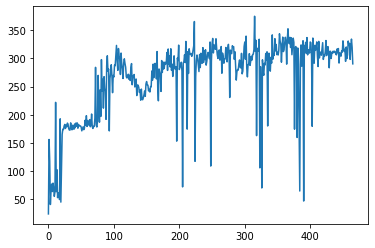

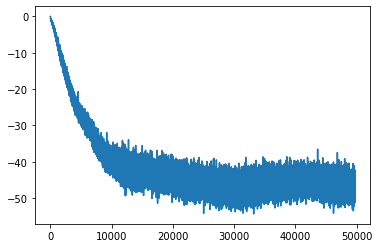

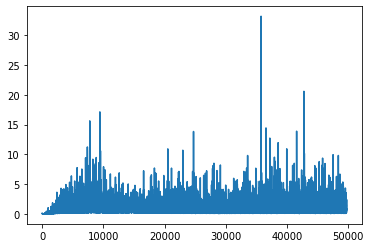

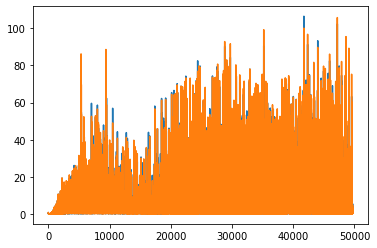

In [14]:
import matplotlib.pyplot as plt

plt.plot(raw_rew_hist)
plt.figure()
plt.plot(pol_loss_hist)
plt.figure()
plt.plot(val_loss_hist)
plt.figure()
plt.plot(q1_loss_hist)
plt.plot(q2_loss_hist)


In [3]:
replay_obs1, replay_obs2, replay_acts, replay_rews, replay_done = replay_buf.sample_batch(replay_batch_size)

In [ ]:
replay_buf.sample_batch()

318.36945331721705


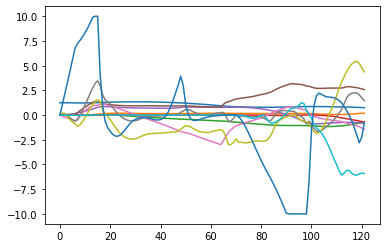

<Figure size 432x288 with 0 Axes>

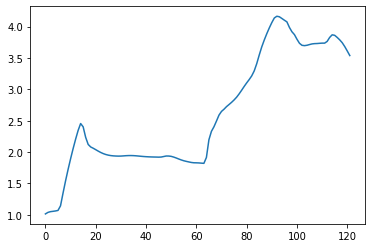

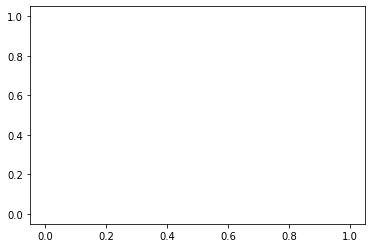

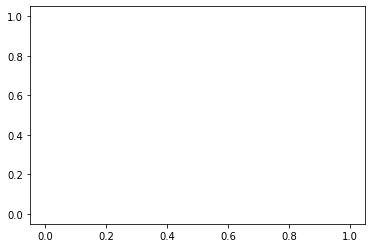

In [13]:
import gym
import torch
env = gym.make(env_name)
done = False
obs = env.reset()

obs_list = []
act_list = []
rew_list = []
avg_list = []
val_list = []

 
dtype = torch.float32
act_size = env.action_space.shape[0]
obs = env.reset()
done = False

while not done:
    model_obs = torch.as_tensor(obs, dtype=dtype).detach() #TODO.... (or not, this still works with ppo right??)
    obs_list.append(obs)
    
    noise = torch.randn(act_size)
    act, logp = model.select_action(model_obs.reshape(1, -1), noise)
    act, _, _, _ = model.step(model_obs.reshape(1, -1))
    act = act.detach()

    obs, rew, done, _ = env.step(act.numpy().reshape(-1))
    #env.render()

    act_list.append(act)
    rew_list.append(rew)

print(sum(rew_list))
plt.plot(obs_list)
plt.figure()
#plt.plot(act_list)
plt.figure()
plt.plot(rew_list)
plt.figure()
plt.plot(val_list)
plt.figure()
plt.plot(avg_list)
    